In [1]:
import os
import random
from IPython.display import display, Markdown

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from sklearn.model_selection import train_test_split


In [2]:
train_image_dir = '../input/airbus-ship-detection/train_v2'
test_image_dir = "../input/airbus-ship-detection/test_v2"
train_images = os.listdir(train_image_dir)
test_images = os.listdir(test_image_dir)

display(f"Total train images: {len(train_images)}", f"Total test images: {len(test_images)}")

'Total train images: 192556'

'Total test images: 15606'

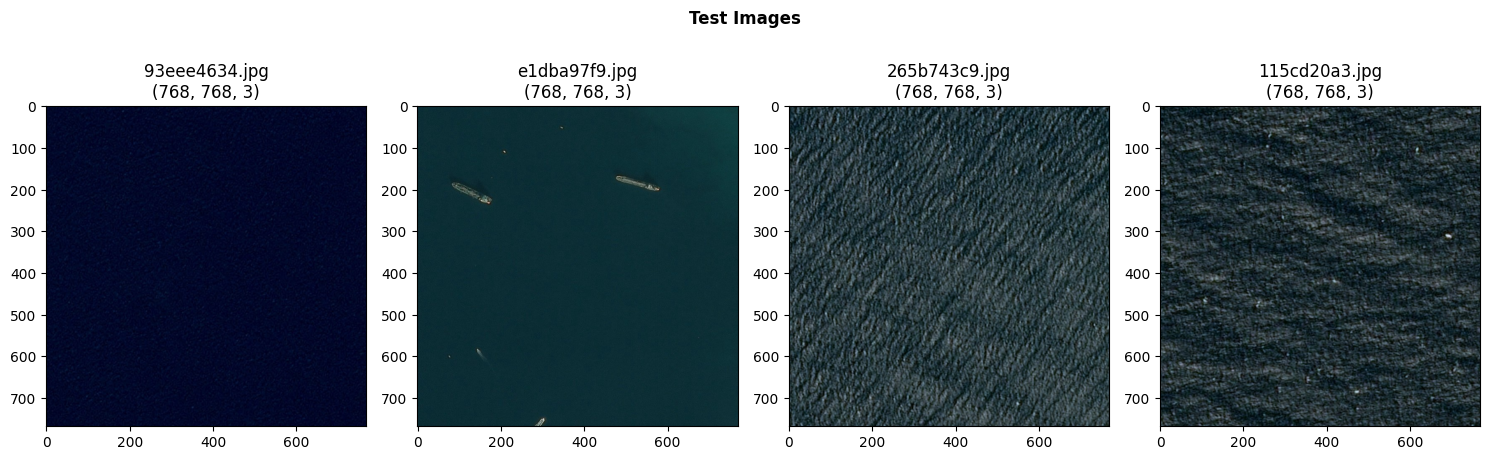

In [3]:
random.seed(42)
num_images = 4

fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
for i in range(num_images):
    random_image = random.choice(train_images)
    image_path = os.path.join(train_image_dir, random_image)
    image = mpimg.imread(image_path)

    ax[i].imshow(image)
    ax[i].set_title(f'{random_image}\n{image.shape}')

fig.suptitle('Test Images', fontweight='bold')
plt.tight_layout()
plt.show()


In [4]:
masks = pd.read_csv("../input/airbus-ship-detection/train_ship_segmentations_v2.csv")

image_ships = masks[masks['ImageId'] == 'e1dba97f9.jpg']
image_no_ships = masks[masks['ImageId'] == '93eee4634.jpg']

display(image_ships, Markdown(f"Number of Ships = {image_ships['EncodedPixels'].notna().sum()}"))
display(image_no_ships, Markdown(f"Number of Ships = {image_no_ships['EncodedPixels'].notna().sum()}"))

,ImageId,EncodedPixels
204276,e1dba97f9.jpg,362676 2 363440 6 364204 11 364968 15 365734 1...
204277,e1dba97f9.jpg,57434 1 58201 3 58968 5 59737 5 60506 5 61274 ...
204278,e1dba97f9.jpg,229619 1 230386 3 231152 5 231919 7 232686 7 2...
204279,e1dba97f9.jpg,109640 2 110408 4 111176 6 111943 8 112711 8 1...
204280,e1dba97f9.jpg,133807 2 134575 4 135342 5 136110 4 136878 4 1...
204281,e1dba97f9.jpg,61634 1 62400 4 63166 6 63932 9 64698 11 65464...


Number of Ships = 6

,ImageId,EncodedPixels
134068,93eee4634.jpg,NaN


Number of Ships = 0

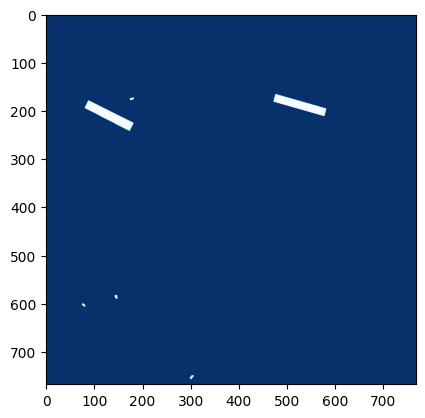

In [5]:
def rleDecode_one(mask: pd.DataFrame) -> np.ndarray:
    shape = (768,768)
    if pd.isna(mask) or mask == 0:
        return np.zeros(shape, dtype=np.uint8)
    pixels = [int(pixel) for pixel in mask.split(' ')]
    starts, lengths = pixels[::2], pixels[1::2]

    mask_rle = np.zeros(shape[0] * shape[1])
    for start, length in zip(starts, lengths):
            mask_rle[start:start+length] = 1 


    return mask_rle.reshape(shape).T

def rleDecode_all(masks: pd.DataFrame) -> pd.DataFrame:
    decoded_masks = []
    for _,row in masks.iterrows():
        decode_mask = rleDecode_one(row['EncodedPixels'])
        decoded_masks.append(decode_mask)
    
    new_masks = masks.copy()
    new_masks['Decoded'] = decoded_masks
    
    return new_masks

def makeImage(masks: pd.DataFrame, image: str) -> np.ndarray:   
    image_df = masks[masks['ImageId'] == image]
    image_df = rleDecode_all(image_df)
    
    combined_image = np.sum(image_df['Decoded'],axis=0)
    combined_image = np.expand_dims(combined_image, -1)
    return combined_image

plt.imshow(makeImage(masks=masks,image='e1dba97f9.jpg'),cmap="Blues_r");

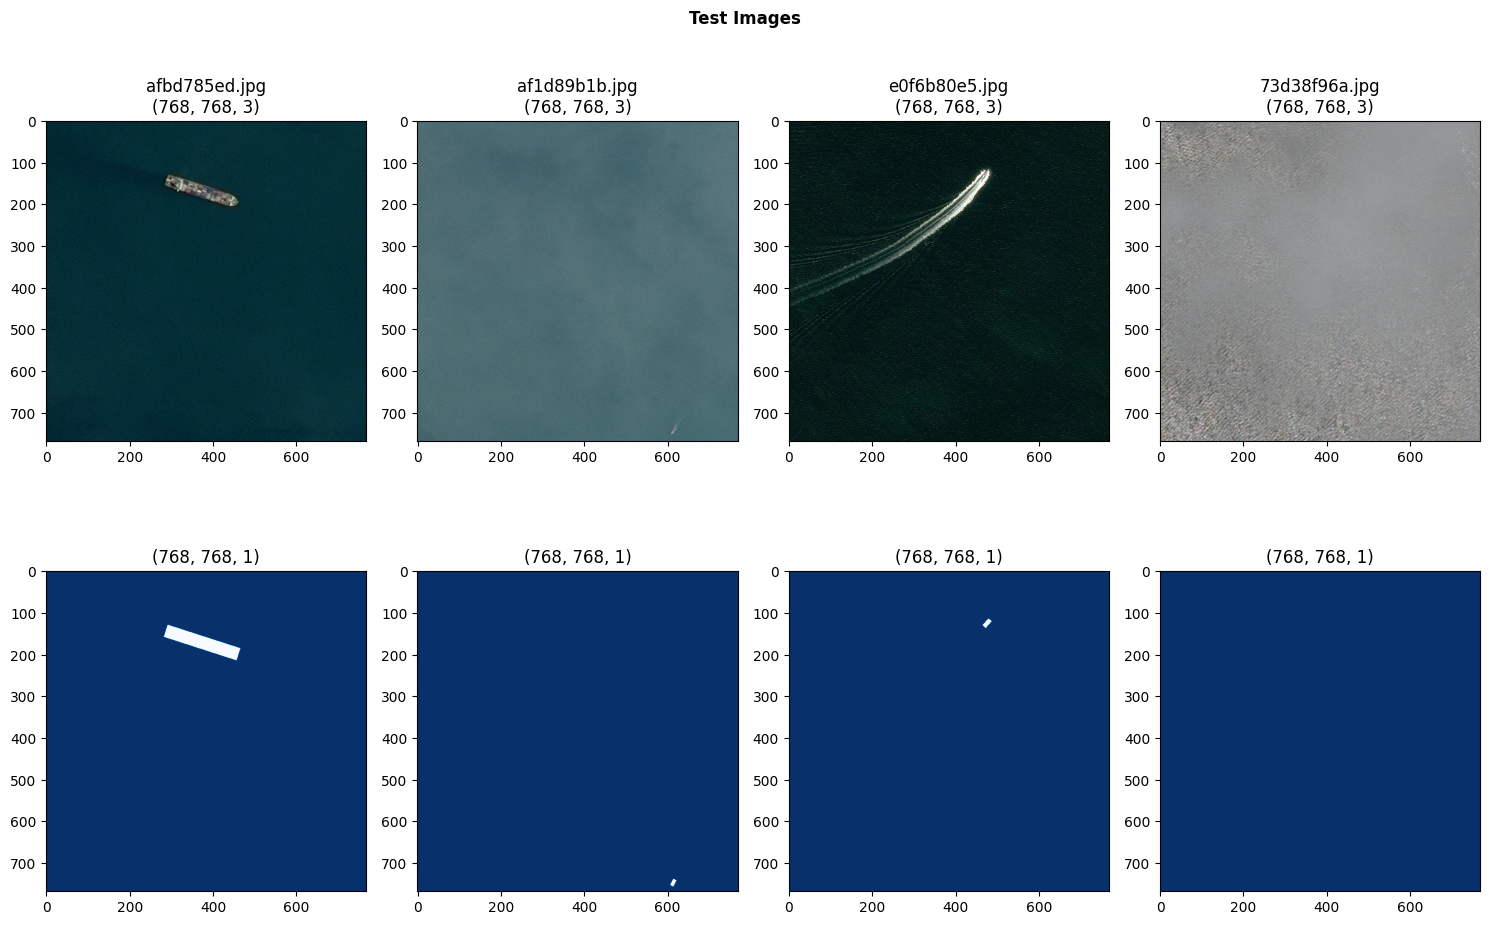

In [6]:
random.seed(7)
num_images = 4

fig, ax = plt.subplots(2, num_images, figsize=(15, 10))

for i in range(num_images):
    random_image = random.choice(train_images)
    image_path = os.path.join(train_image_dir, random_image)
    image = mpimg.imread(image_path)

    mask_image = makeImage(masks=masks, image=random_image)
    
    ax[0, i].imshow(image)
    ax[1, i].imshow(mask_image, cmap='Blues_r')
    ax[0, i].set_title(f'{random_image}\n{image.shape}')
    ax[1, i].set_title(mask_image.shape)

fig.suptitle('Test Images', fontweight='bold')
plt.tight_layout()
fig.show()

In [7]:
mask_by_ships = masks.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.notna().sum()).reset_index()
mask_by_ships = mask_by_ships.rename(columns={'EncodedPixels':'ships'})
display(mask_by_ships.head(5))

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [8]:
mask_by_ships['has_ship'] = mask_by_ships['ships'].apply(lambda x: 0 if x == 0 else 1)
display(mask_by_ships.head(5))

,ImageId,ships,has_ship
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,1,1
3,000194a2d.jpg,5,1
4,0001b1832.jpg,0,0


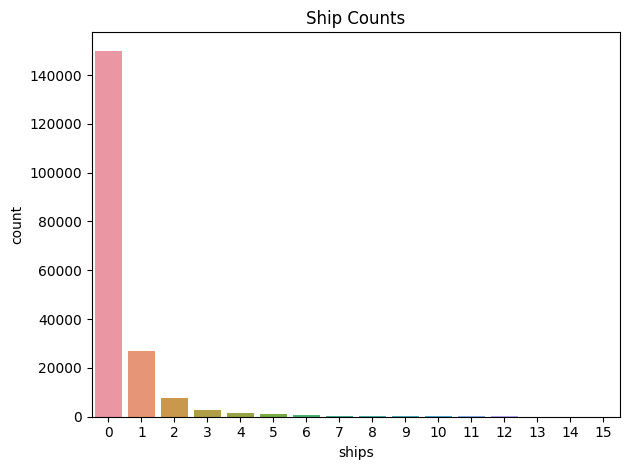

ships
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

In [9]:
sns.countplot(data=mask_by_ships, x='ships',)
plt.title('Ship Counts')

plt.tight_layout()
plt.show()
display(mask_by_ships['ships'].value_counts())

In [10]:
mask_by_ships['ships_binned'] = pd.cut(mask_by_ships['ships'],
                                       bins=[-1, 0, 2, 4, 7, 15],
                                       labels=[0, 1, 2, 3, 4]).astype(int)

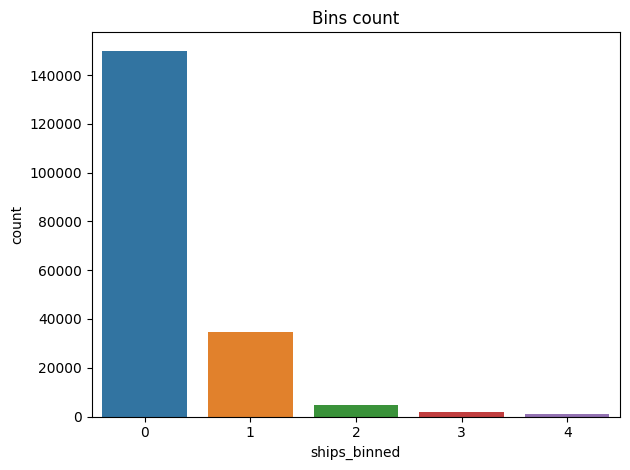

ships_binned
0    150000
1     34778
2      4576
3      1988
4      1214
Name: count, dtype: int64

In [11]:
sns.countplot(data=mask_by_ships, x='ships_binned',)
plt.title('Bins count')

plt.tight_layout()
plt.show()
display(mask_by_ships['ships_binned'].value_counts())

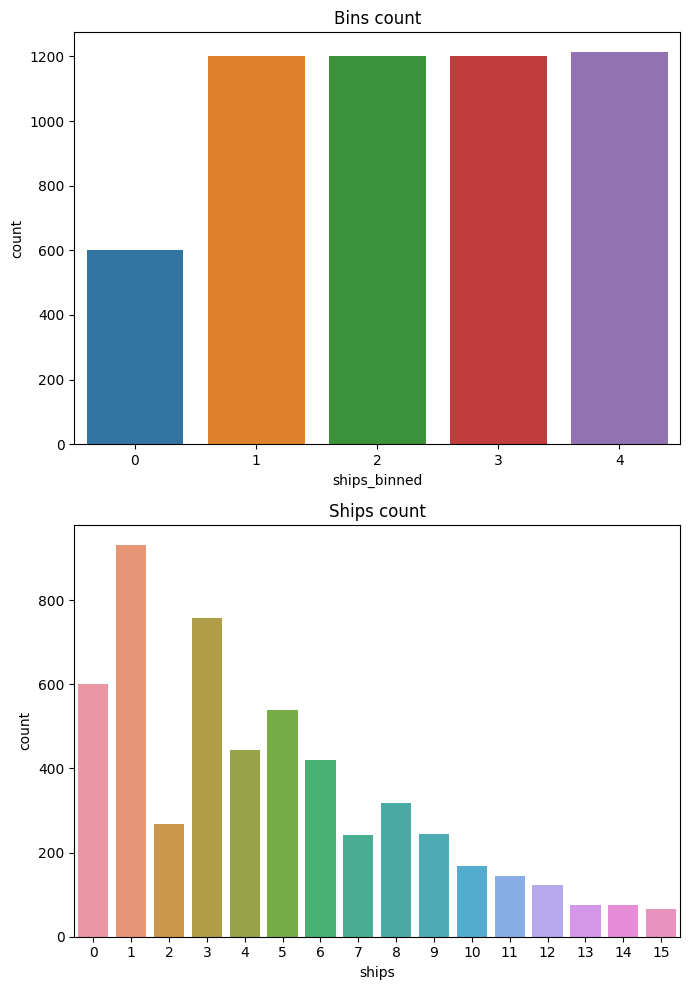

In [12]:
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy = {0:600, 1:1200, 2:1200, 3:1200, 4:1214}
rand_sampler = RandomUnderSampler(random_state=42,
                                 sampling_strategy=sampling_strategy
                                 )

ships_resampled, _ = rand_sampler.fit_resample(mask_by_ships, 
                                               mask_by_ships['ships_binned'],
                                               )

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.countplot(data=ships_resampled, x='ships_binned', ax=ax[0])
ax[0].set_title('Bins count')

sns.countplot(data=ships_resampled, x='ships', ax=ax[1])
ax[1].set_title('Ships count')

plt.tight_layout()
plt.show()


In [13]:
#masks_df = pd.merge(masks, ships_resampled)

#sns.countplot(data=masks_df, x='ships',)
#plt.title('Ships count')
#plt.tight_layout()
#plt.show()

In [14]:
train_df, valid_df = train_test_split(ships_resampled, test_size=0.3, stratify=ships_resampled['ships'])
train_df = pd.merge(masks, train_df)
valid_df = pd.merge(masks, valid_df)

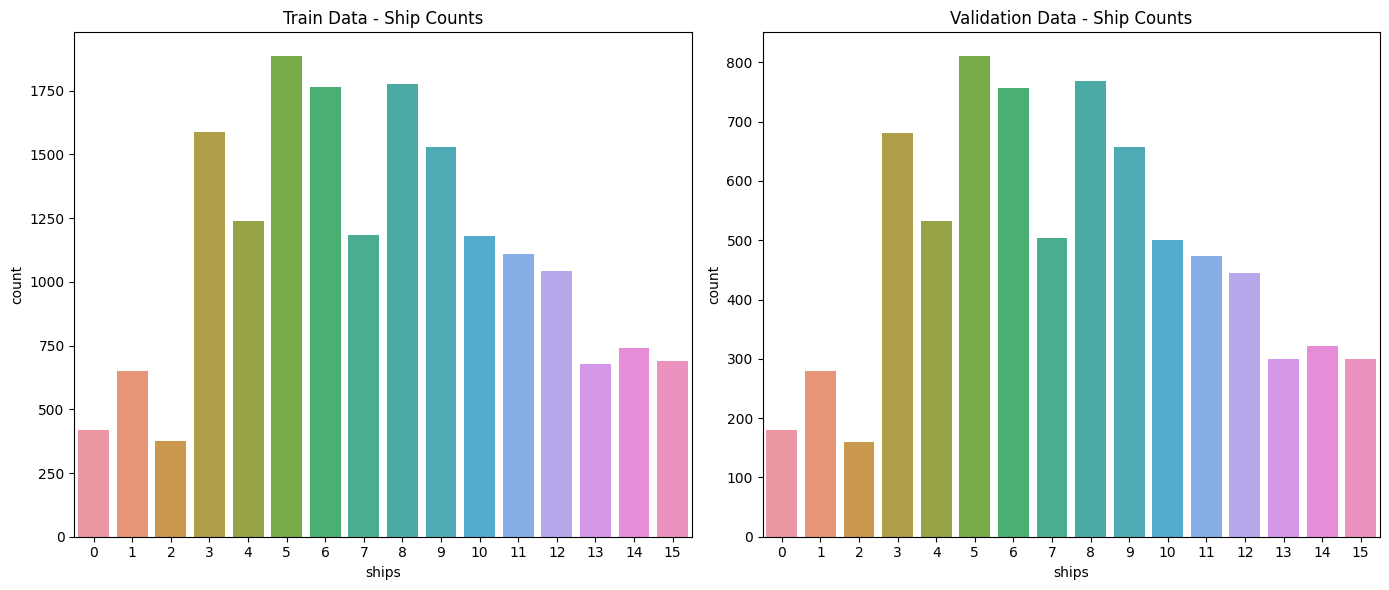

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df, x='ships', ax=ax[0])
ax[0].set_title('Train Data - Ship Counts')

sns.countplot(data=valid_df, x='ships',ax=ax[1])
ax[1].set_title('Validation Data - Ship Counts')

plt.tight_layout()
plt.show()

In [16]:
display(train_df)

,ImageId,EncodedPixels,ships,has_ship,ships_binned
0,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9,1,4
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9,1,4
2,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...,9,1,4
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9,1,4
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,9,1,4
...,...,...,...,...,...
17854,ffe89d4cb.jpg,79695 1 80462 3 81228 6 81995 7 82762 9 83529 ...,3,1,2
17855,ffe89d4cb.jpg,569214 1 569981 3 570748 5 571515 7 572282 10 ...,3,1,2
17856,ffef7c3f3.jpg,434402 2 435169 5 435937 6 436704 7 437472 6 4...,3,1,2
17857,ffef7c3f3.jpg,119822 1 120589 3 121356 5 122123 7 122890 9 1...,3,1,2


In [17]:
# Parameters
BATCH_SIZE = 4                 # Train batch size
EDGE_CROP = 16                 # While building the model
NB_EPOCHS = 5                  # Training epochs
GAUSSIAN_NOISE = 0.1           # To be used in a layer in the model
UPSAMPLE_MODE = 'SIMPLE'       # SIMPLE ==> UpSampling2D, else Conv2DTranspose
NET_SCALING = None             # Downsampling inside the network                        
IMG_SCALING = (1, 1)           # Downsampling in preprocessing
VALID_IMG_COUNT = 400          # Valid batch size
MAX_TRAIN_STEPS = 200          # Maximum number of steps_per_epoch in training

In [18]:
def makeImage_gen(df: pd.DataFrame, BATCH_SIZE: int) -> np.ndarray: 
    unique_images = df['ImageId'].unique()
    rgb = []
    mask = []
    
    while True:
        np.random.shuffle(unique_images)
        for image in unique_images:
            combined_image = makeImage(df,image)
            
            rgb_path = os.path.join(train_image_dir, image)
            img = mpimg.imread(rgb_path)
            
            mask.append(combined_image)         
            rgb.append(img)


            if len(rgb) == BATCH_SIZE:
                combined_rgb = np.stack(rgb)/255
                combined_mask = np.stack(mask)
                
                yield combined_rgb, combined_mask
                
                rgb.clear()
                mask.clear()


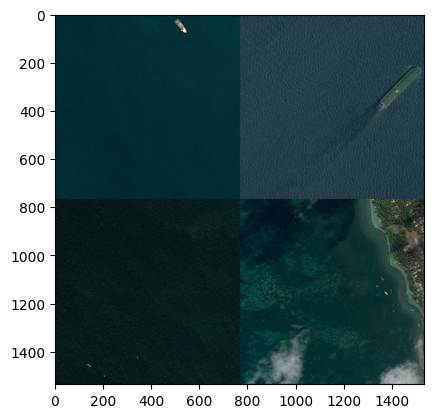

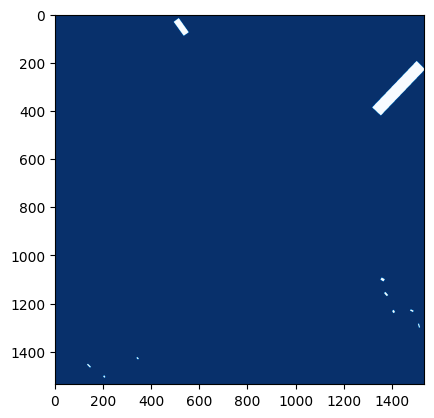

In [19]:
train_gen = makeImage_gen(train_df,4)
train_X, train_y = next(train_gen)
def montageRgb (batch: np.ndarray) -> np.ndarray:
    montage_lst = []
    for channel in range(batch.shape[3]):
        montage_lst.append(montage(batch[:,:,:,channel]))
    return np.stack(montage_lst,-1)
        
rgb_batch = montageRgb(train_X)
batch_seg = montage(train_y[:, :, :, 0])     
plt.imshow(rgb_batch)
plt.show()
plt.imshow(batch_seg, cmap='Blues_r')
plt.show()